# <font color=blue>Basic Signal Processing Using NumPy</font>

__We review some basic concepts in class:__

* Time domain signal: continuous vs digital
* Signal Digitization: Sampling and Quantization
* Sampling theorem: Nyquist rate and Aliasing
* Frequency domain representation and Fast Fourier Transfor (FFT)
* Convolution and Filtering

__Let's use some NumPy signal processing module to perform those functions.__

In [4]:
import numpy as np
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt
%matplotlib inline

## Scipy package for audio processing

In [5]:
from scipy.io.wavfile import read, write
from IPython.display import Audio

## <font color=green> Generate Sine Waves
    
__Sinusoids (sine and cosine) are fundamental periodic waveforms that can be used to constructed any type of singlas. The continuous-time sine wave is given by__
    
__$f(t) = A\cdot sin(2\pi f_c t)$, where A = amplitude and $f_c=$ frequency.__
    
__For discrete time sinewave, we will specify the sampling rate, $f_s$, to produce the discrete time sequence.__ 

In [6]:
def sine_wave(freq, sample_rate, duration):
    '''Discrete-time sine wave generator'''
    
    t = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    y = np.sin((2 * np.pi) * freq * t)
    return t, y

__Create a 1-second sinewave of $f_c=$ 200Hz. Sampling rate = 20,000 Hz__

* Oversampling Rate = $f_s \over f_c$ = 20000/200 = 100

In [7]:
fs = 20000

duration = 1  # 1-second 

f = 200    # the center frequency

time, x = sine_wave(f, fs, duration)

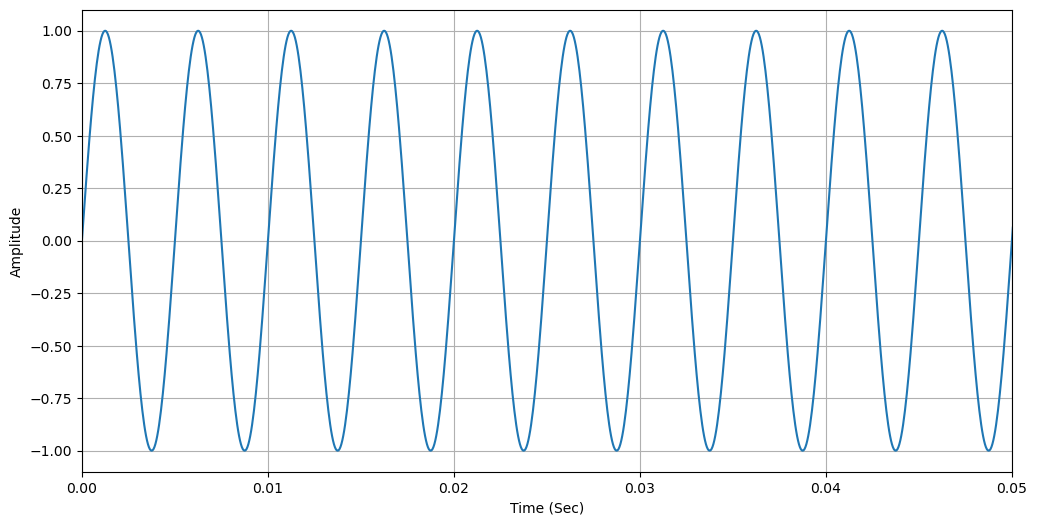

In [8]:
plt.figure(figsize=(12,6))
plt.plot(time, x)
plt.xlim(0, 0.05)  # plot only 0.05sec

plt.xlabel('Time (Sec)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

### Exercise: Change the sampling rate fs and see the effect on the signal

## <font color=green>Quantization on the singal amplitudes

In [9]:
# The sinewave generated here are floating numbers, or analog.
x.dtype

dtype('float64')

In [10]:
# Obviously, the max = 1 and min = -1
print (x.min(), x.max())

-1.0 1.0


In [11]:
def quantize(x, n_bits):
    '''Quantize the input signals to desired bit length'''
    
    n_levels = 2**n_bits
    bins = np.linspace(x.min(), x.max(), n_levels, endpoint=True)
    
    return np.digitize(x, bins) - 2**(n_bits-1)


### Quantize the amplitude to 256 levels, or, 8-bits

In [12]:
q_x = quantize(x, n_bits=4)

q_x.min(), q_x.max()

(-7, 8)

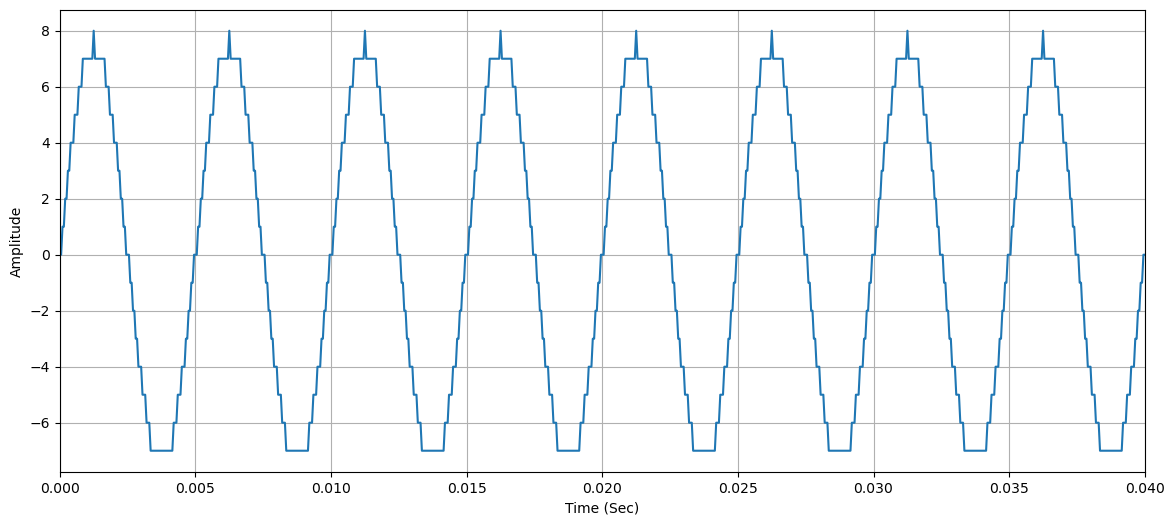

In [13]:
plt.figure(figsize=(14,6))
plt.plot(time, q_x)
plt.xlim(0, 0.04)

plt.xlabel('Time (Sec)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

### Let's listen to the sinewaves which are basically a tone with fixed frequency. 

In [14]:
## Modules from scipy for audio playback

from scipy.io.wavfile import read, write
from IPython.display import Audio, display

In [15]:
print('Original signal (float64)')
display(Audio(data=x, rate=fs))

# And play the audio at each bit depth
for bits in [16, 8, 4, 2, 1]:
    print('{}-bit'.format(bits))
    display(Audio(data=quantize(x, bits), rate=fs))

Original signal (float64)


16-bit


8-bit


4-bit


2-bit


1-bit


## <font color=green> Frequency domain reprsentation of the sine waves
### Fast Fourier Transform will dispaly the digital signal in the frequency domain 

In [16]:
def calc_fft(signal,fs):
    '''This function calculates N=point FFT of the input signal'''
    
    N = signal.size
    n = np.arange(N)
    freqs = n*fs/N                 # the N frequencies
    mag_fft = abs(fft(signal)/N)   # calculate the magnitude of FFT
    return freqs, mag_fft


In [17]:
fs = 20000
duration = 1  # 1-second 
f = 200    # the center frequency
time, x = sine_wave(f, fs, duration)

freq, mag = calc_fft(x, fs)

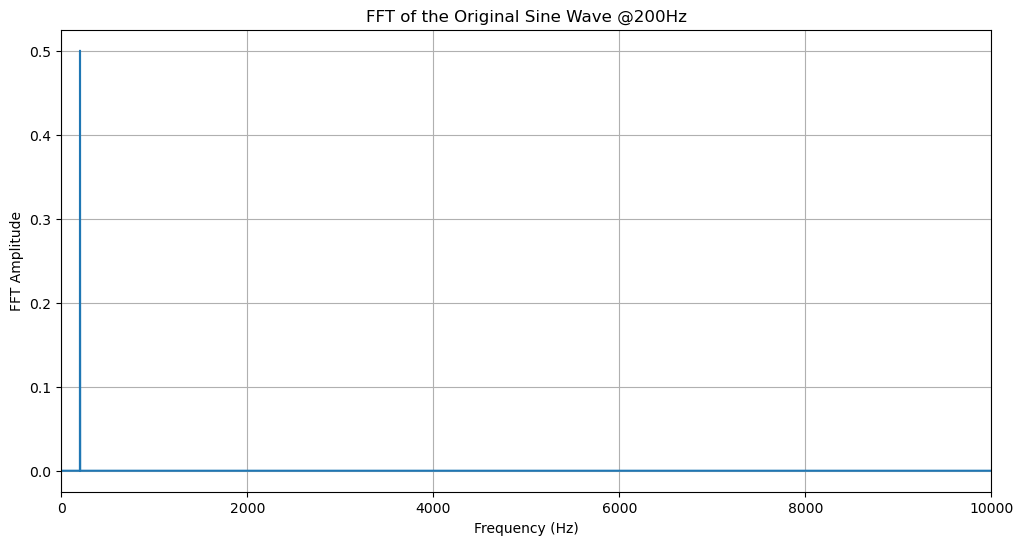

In [18]:
plt.figure(figsize=(12,6))
plt.plot(freq, mag)
plt.xlim(0, fs/2)  # A single peak at 200Hz


plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.title('FFT of the Original Sine Wave @200Hz')
plt.grid()

plt.show()

In [21]:
bits = 1
data=quantize(x, bits)

freq, mag = calc_fft(data, fs)

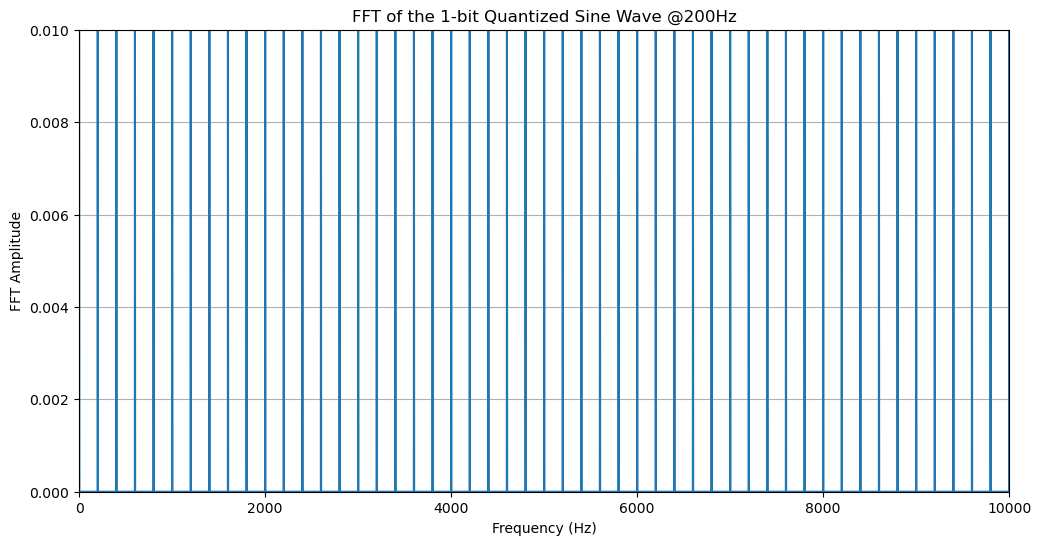

In [22]:
plt.figure(figsize=(12,6))
plt.plot(freq, mag)
plt.xlim(0, fs/2)
plt.ylim(0, mag.max())
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.title(f'FFT of the {bits}-bit Quantized Sine Wave @200Hz')
plt.grid()

plt.show()

### What if the sampling rate falls below Nquist rate? Alising!

In [265]:
# Create a 10-second sinewave of 200Hz.
fs = 300
duration = 10  

f = 200    # the center frequency
time, y = sine_wave(f, fs, duration)

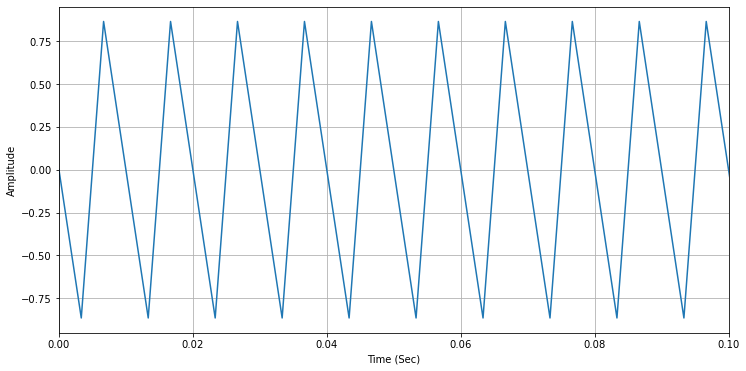

In [212]:
plt.figure(figsize=(12,6))
plt.plot(time, y)
plt.xlim(0, 0.1)

plt.xlabel('Time (Sec)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

### Check out the frequency response. Note that an unwanted tone at 100Hz shows up that is the result of aliasing.

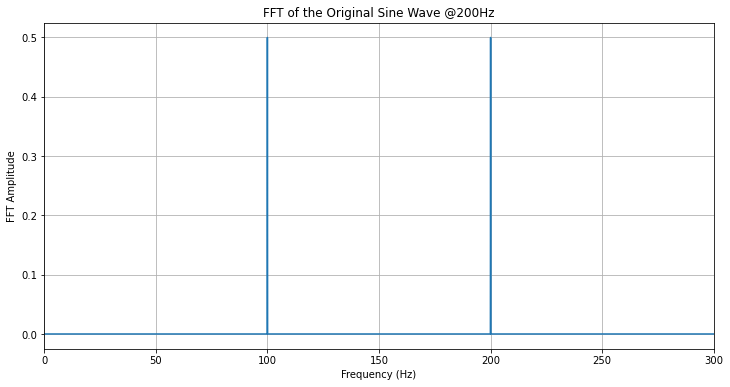

In [213]:
freq, mag = calc_fft(y, fs)

plt.figure(figsize=(12,6))
plt.plot(freq, mag)
plt.xlim(0, fs)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.title('FFT of the Original Sine Wave @200Hz')
plt.grid()

plt.show()

### Exercise: Change the sampling rate (under Nyquist) and see what the spectrum looks like.

## <font color=green> Filtering and Convolution

### Use Numpy convolution to create a simple moving average filter

__Create a noisy signal by adding Gaussian noise to a clean sinewave.__

In [24]:
## Clean signal
fs = 10000
duration = 1  

f = 200    # the center frequency
time, y = sine_wave(f, fs, duration)

## Adding Gaussian noise (mu=0, std=1) to each sample in y
noise = 0.5*np.random.normal(0, 1, size=y.size)

signal = y +noise

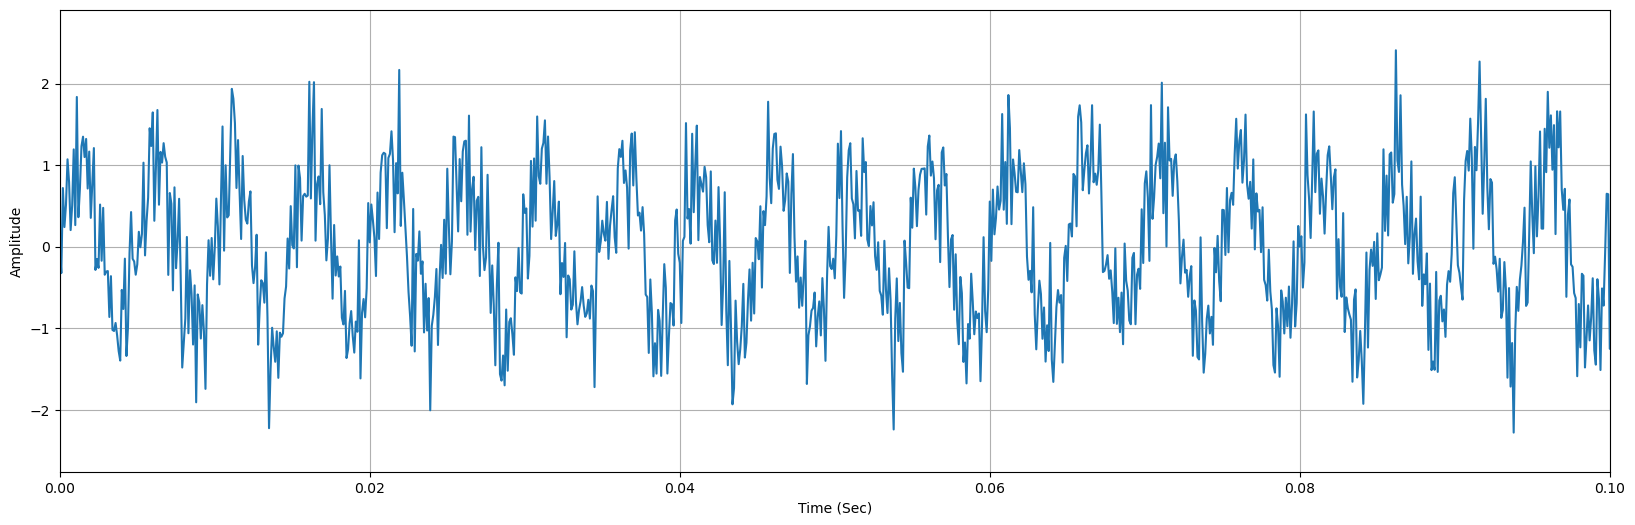

In [25]:
plt.figure(figsize=(20,6))
plt.plot(time, signal)
plt.xlim(0, 0.1)

plt.xlabel('Time (Sec)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

### Implement a simple moving average filter (low-pass)

__The filtered output, $y[n]$, is given by $y[n] = \sum_{i=0}^{N-1}x[n-i] \cdot {1 \over L}$__

In [27]:
L = 5 # filter size

filter_kernel = np.ones(L) / L

filtered_signal = np.convolve(signal, filter_kernel, mode='same')
filtered_signal.size

10000

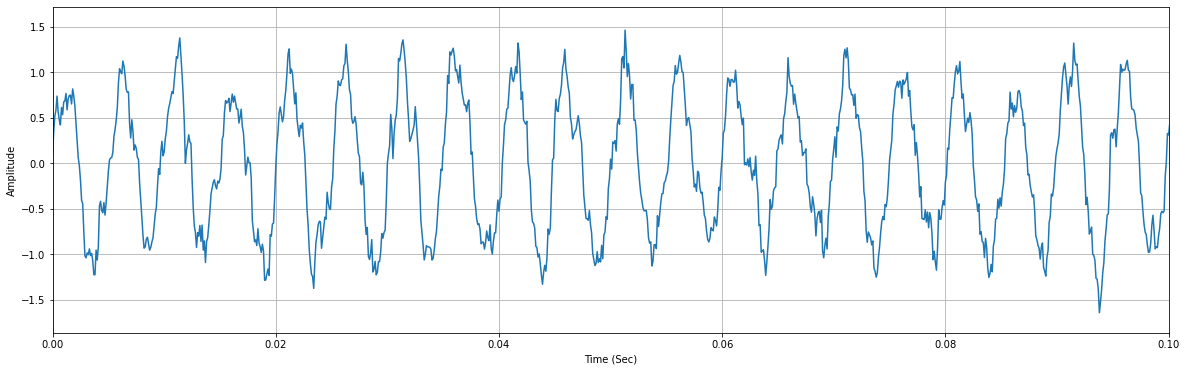

In [223]:
plt.figure(figsize=(20,6))
plt.plot(time, filtered_signal)
plt.xlim(0, 0.1)

plt.xlabel('Time (Sec)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

### Frequency Domain View of the noisy signal and the filtered signal

__Use FFT to transform the time domain signals to frequency domain.__

In [28]:
## Noisy signal
fs = 10000
freq, mag = calc_fft(signal, fs)

freq, mag1 = calc_fft(filtered_signal, fs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


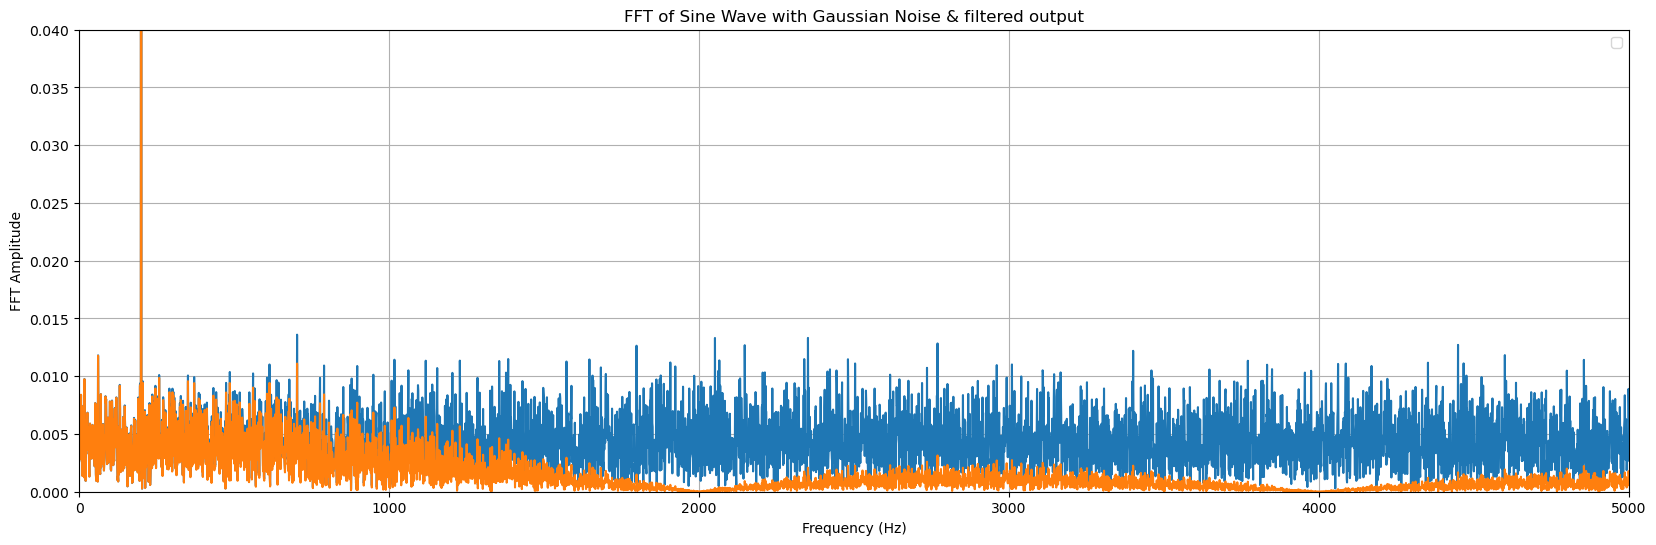

In [29]:
plt.figure(figsize=(20,6))
plt.plot(freq, mag, freq, mag1)
plt.xlim(0, fs/2)
plt.ylim(0, 0.04) #mag.max()

plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.title(f'FFT of Sine Wave with Gaussian Noise & filtered output')

plt.grid()
plt.show()

## <font color=green>Human voice

In [229]:
Fs, data = read('speech sample 8kHz.wav')

print (type(data))
print (data.size)

print ('Sampling rate =', Fs)

<class 'numpy.ndarray'>
178240
Sampling rate = 16000


In [230]:
print (data.dtype)
print (data.shape)
print ('rank of data =', data.ndim)

int16
(178240,)
rank of data = 1


In [231]:
Audio(data, rate = Fs)

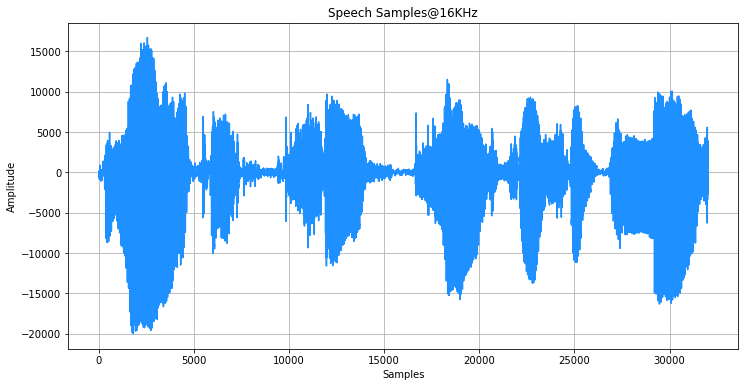

In [233]:
plt.figure(figsize=(12,6))
plt.plot(data[:32000], c='dodgerblue')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Speech Samples@16KHz')

plt.grid()
plt.show()

### Frequency Domain of the speech signal 

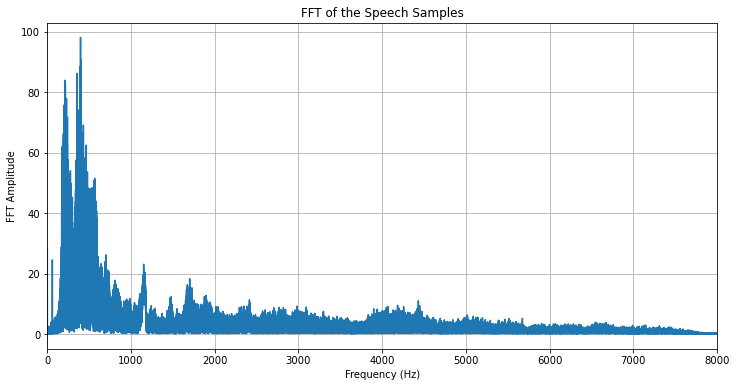

In [134]:
freq, mag = calc_fft(data, Fs)

plt.figure(figsize=(12,6))
plt.plot(freq, mag)
plt.xlim(0, Fs/2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.title('FFT of the Speech Samples')
plt.grid()

plt.show()

## <font color=green> White Noice

In [238]:
# Generating a well-know normal distribution bell curve
# using random.normal() funciton

# mean = 0, std = 1
noise = np.random.normal(0, 1, 200000)

In [239]:
Fs = 44100
out_f = 'out.wav'

write(out_f, Fs, data)

In [240]:
Audio(noise, rate = Fs)

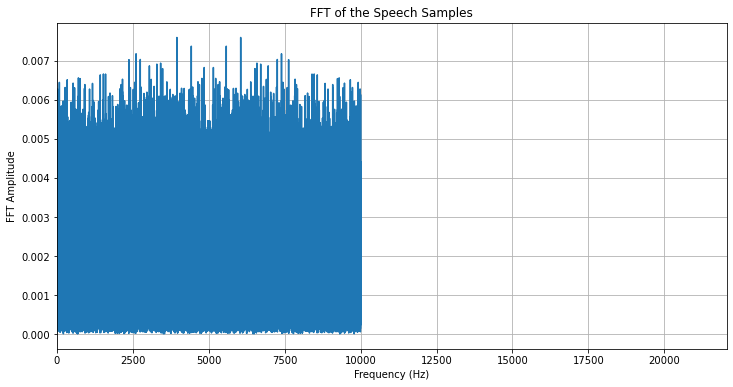

In [242]:
freq, mag = calc_fft(noise, fs)

plt.figure(figsize=(12,6))
plt.plot(freq, np.abs(mag))
plt.xlim(0, Fs/2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')
plt.title('FFT of the Speech Samples')
plt.grid()

plt.show()

### You can change the sampling rate to 16KHz or 8KHz and hear the difference